In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def Black76Call(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(S*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*log(F/X)
        zhi = log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [3]:
#IRR function 
def IRR(x,N,m):
    IRR=np.zeros(N*m)
    IRRS=0
    for i in range(N*m):
        IRR[i]= 1/m / (1+x/m)**i
    IRRS=np.sum(IRR[:])
    return IRRS
# first derivative of IRR
def IRRf(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRf = (IRRplus - IRRminus) / (2*dx)
    return IRRf
# second derivative of IRR
def IRRff(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRx = IRR(x,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRff = (IRRplus - 2*IRRx + IRRminus) / (dx**2)
    return IRRff
# second derivative of payoff function
def hff(x, N, m,F, sigma, T):
    h = (-IRRff(x,N,m) * x - 2 * IRRf(x,N,m) ) / (IRR(x,N,m)**2) +\
        2 * IRRf(x,N,m)**2 * x / IRR(x,N,m)**3
    return h
# receiver payoff convexity part
def integral1(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vrec = Black76Put(F, x, disc,sigma, T)
    return h*Vrec
# payer swaptions convexity part
def integral2(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vpay = Black76Call(F, x, disc,sigma, T)
    return h*Vpay

# Calculate the CMS Rates

In [4]:
alpha = pd.read_csv('sabr_alpha.csv', header = 0, index_col = 0 )
rho = pd.read_csv('sabr_rho.csv', header = 0, index_col = 0)
nu = pd.read_csv('sabr_nu.csv', header = 0, index_col = 0)
# get the Sn,N data to prepare to calculate the CMS rate
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)

In [45]:
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [5]:
Expiry = ['1Y','5Y','10Y']
Tenor = ['1Y','2Y','3Y','5Y','10Y']

In [6]:
CMS_Rate=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
CMS_Rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.0,0.0,0.0,0.0,0.0
5Y,0.0,0.0,0.0,0.0,0.0
10Y,0.0,0.0,0.0,0.0,0.0


In [7]:
# use CMS replication payoff function to calculate the CMS rate
# semi annually payment frequency
for ex in Expiry:
    for te in Tenor:
        F = fsr.loc[ex, te]
        T = int(ex.strip()[:-1])
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        
        # N is the number of the swap tenor
        N = te_int
        sigma = SABR(F, F, T, alpha.loc[ex, te], 0.9, rho.loc[ex, te], nu.loc[ex,te])
        term1 = quad(lambda x:integral1(x,N,1,F,IRR(F, N, 2), sigma, T),0,F)
        term2 = quad(lambda x:integral2(x,N,1,F,IRR(F, N, 2), sigma,
                                        T),F,np.inf)
        
        CMS_Rate.loc[ex,te] = F + np.sum(term1 + term2)

In [8]:
CMS_Rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033302,0.034108,0.035416,0.038802
5Y,0.039274,0.040468,0.040879,0.042379,0.046321
10Y,0.042189,0.044145,0.046311,0.050092,0.062396


In [9]:
FW_rate = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
FW_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [10]:
# check the difference

In [11]:
comparison = []
for x in Expiry:
    for y in Tenor:
        rate_diff =  CMS_Rate.loc[x,y] - FW_rate.loc[x,y]
        comparison.append(rate_diff)

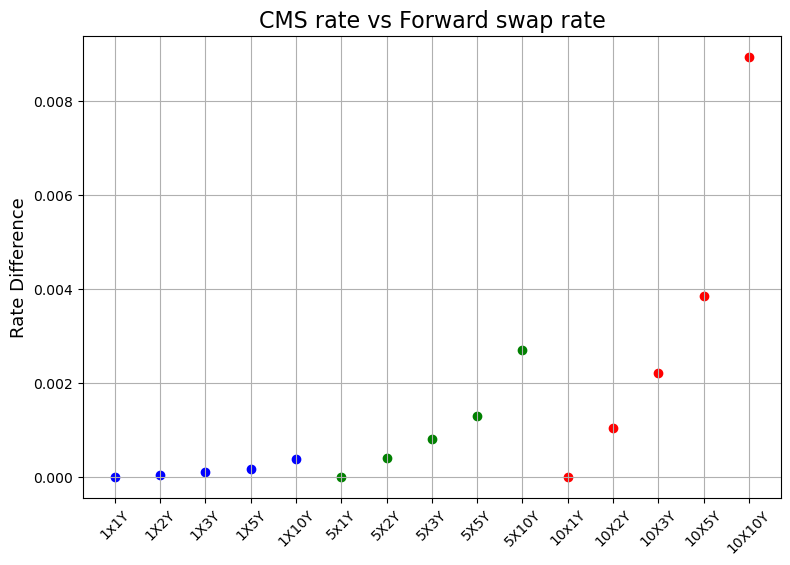

In [12]:
plt.figure(figsize = (9, 6))
plt.scatter(['1x1Y', '1X2Y', '1X3Y', '1X5Y', '1X10Y'], comparison[:5], c = 'b')
plt.scatter(['5x1Y', '5X2Y', '5X3Y', '5X5Y', '5X10Y'], comparison[5:10], c = 'g')
plt.scatter(['10x1Y', '10X2Y', '10X3Y', '10X5Y', '10X10Y'], comparison[10:], c = 'r')
plt.grid()
plt.xticks(rotation = 45)
plt.title('CMS rate vs Forward swap rate', fontsize = 16)
plt.ylabel('Rate Difference', fontsize = 13);

> There is minor difference between the CMS rate and forward swap rate. This is because the CMS is valued at a wrong time. The forward swap rate is determined today $T_{0}$ and payoff at the $T_{1}$. But the CMS rate is paid at $T_{1}$. So, if we were using the forward rate to value CMS product, we need some convexity corrections to calibrate the price of CMS.From the comparison table we have above, we can see that the longer the tenor, the higher the difference between the CMS rate product and forward rate. This may be due to the longer the tenor, we need more swaptions to do convexity corrections, which will cause higher trancation errors during the whole process, leading to a higher difference between the CMS and forward rate 

# Calculate the CMS Present Value Semi Annually Over Next 5 Years

In [13]:
dis = pd.read_csv('discount_factor.csv', header = 0)
dis.head()

,Tenor,OIS_Discount,Libor_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330


In [14]:
start = ['0.5Y', '1Y', '1.5Y', '2Y', '2.5Y', '3Y', '3.5Y',
        '4Y', '4.5Y', '5Y']
tenor = ['10Y']

In [15]:
forward = []
for ex in start:
    for te in tenor:
        i = float(ex.strip()[:-1])
        j = float(te.strip()[:-1])
        deno = 0.5*sum(dis.OIS_Discount[int(2*i):int(2*(i+j))])
        
        terms = []
        for x in range(int(2*i), int(2*(i+j))):
            no = dis.OIS_Discount[x] * (dis.Libor_DF[x-1] - dis.Libor_DF[x])/dis.Libor_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        forward.append(numer/deno)

In [16]:
data = pd.DataFrame({'Start': start, 'Tenor':tenor * 10, 
              'FS' : forward,
              'DF' : dis.OIS_Discount[:10],
              'alpha': np.NaN,
              'rho': np.NaN,
              'nu': np.NaN})
data

,Start,Tenor,FS,DF,alpha,rho,nu
0,0.5Y,10Y,0.037845,0.998752,NaN,NaN,NaN
1,1Y,10Y,0.038428,0.997009,NaN,NaN,NaN
2,1.5Y,10Y,0.039020,0.995270,NaN,NaN,NaN
3,2Y,10Y,0.039634,0.993531,NaN,NaN,NaN
4,2.5Y,10Y,0.040200,0.991773,NaN,NaN,NaN
5,3Y,10Y,0.040788,0.990015,NaN,NaN,NaN
6,3.5Y,10Y,0.041412,0.988066,NaN,NaN,NaN
7,4Y,10Y,0.042062,0.986117,NaN,NaN,NaN
8,4.5Y,10Y,0.042831,0.984150,NaN,NaN,NaN
9,5Y,10Y,0.043634,0.982184,NaN,NaN,NaN


In [17]:
alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139061,0.184649,0.196849,0.178051,0.171073
5Y,0.166499,0.199385,0.209731,0.188195,0.172197
10Y,0.177136,0.193791,0.204197,0.192592,0.167843


In [18]:
rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633280,-0.525117,-0.482843,-0.414413,-0.264900
5Y,-0.584968,-0.546346,-0.547256,-0.493732,-0.392101
10Y,-0.544353,-0.539995,-0.542701,-0.534139,-0.443578


In [19]:
nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049672,1.677407,1.438152,1.064907,0.778199
5Y,1.339284,1.061521,0.936034,0.680061,0.530337
10Y,1.005600,0.921104,0.862169,0.713666,0.599924


In [20]:
# plug the known alpha, rho, nu  and then interpolate
data.iloc[1,4] = 0.171073
data.iloc[9,4] = 0.172197
data.iloc[1,5] = -0.264900
data.iloc[9,5] = -0.392101
data.iloc[1,6] = 0.778199
data.iloc[9,6] = 0.530337

In [21]:
data['alpha'] = data.alpha.interpolate(limit_direction = 'both')
data['nu'] = data.nu.interpolate(limit_direction = 'both')
data['rho'] = data.rho.interpolate(limit_direction = 'both')

In [22]:
data

,Start,Tenor,FS,DF,alpha,rho,nu
0,0.5Y,10Y,0.037845,0.998752,0.171073,-0.264900,0.778199
1,1Y,10Y,0.038428,0.997009,0.171073,-0.264900,0.778199
2,1.5Y,10Y,0.039020,0.995270,0.171213,-0.280800,0.747216
3,2Y,10Y,0.039634,0.993531,0.171354,-0.296700,0.716233
4,2.5Y,10Y,0.040200,0.991773,0.171494,-0.312600,0.685251
5,3Y,10Y,0.040788,0.990015,0.171635,-0.328500,0.654268
6,3.5Y,10Y,0.041412,0.988066,0.171775,-0.344401,0.623285
7,4Y,10Y,0.042062,0.986117,0.171916,-0.360301,0.592302
8,4.5Y,10Y,0.042831,0.984150,0.172057,-0.376201,0.561320
9,5Y,10Y,0.043634,0.982184,0.172197,-0.392101,0.530337


In [23]:
data['CMS'] = np.NaN
data

,Start,Tenor,FS,DF,alpha,rho,nu,CMS
0,0.5Y,10Y,0.037845,0.998752,0.171073,-0.264900,0.778199,NaN
1,1Y,10Y,0.038428,0.997009,0.171073,-0.264900,0.778199,NaN
2,1.5Y,10Y,0.039020,0.995270,0.171213,-0.280800,0.747216,NaN
3,2Y,10Y,0.039634,0.993531,0.171354,-0.296700,0.716233,NaN
4,2.5Y,10Y,0.040200,0.991773,0.171494,-0.312600,0.685251,NaN
5,3Y,10Y,0.040788,0.990015,0.171635,-0.328500,0.654268,NaN
6,3.5Y,10Y,0.041412,0.988066,0.171775,-0.344401,0.623285,NaN
7,4Y,10Y,0.042062,0.986117,0.171916,-0.360301,0.592302,NaN
8,4.5Y,10Y,0.042831,0.984150,0.172057,-0.376201,0.561320,NaN
9,5Y,10Y,0.043634,0.982184,0.172197,-0.392101,0.530337,NaN


In [24]:
# get thte CMS rate 
for i in range(0, 10):
    F = data.FS[i]
    T = (i+1)/2
    N = 10
    m = 2 #semi-annually
    sigma = SABR(F, F, T, data.alpha[i], 0.9, data.rho[i],data.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    data.CMS[i] = F + np.sum(term1 + term2)

In [25]:
data

,Start,Tenor,FS,DF,alpha,rho,nu,CMS
0,0.5Y,10Y,0.037845,0.998752,0.171073,-0.264900,0.778199,0.038037
1,1Y,10Y,0.038428,0.997009,0.171073,-0.264900,0.778199,0.038844
2,1.5Y,10Y,0.039020,0.995270,0.171213,-0.280800,0.747216,0.039688
3,2Y,10Y,0.039634,0.993531,0.171354,-0.296700,0.716233,0.040582
4,2.5Y,10Y,0.040200,0.991773,0.171494,-0.312600,0.685251,0.041448
5,3Y,10Y,0.040788,0.990015,0.171635,-0.328500,0.654268,0.042359
6,3.5Y,10Y,0.041412,0.988066,0.171775,-0.344401,0.623285,0.043325
7,4Y,10Y,0.042062,0.986117,0.171916,-0.360301,0.592302,0.044335
8,4.5Y,10Y,0.042831,0.984150,0.172057,-0.376201,0.561320,0.045489
9,5Y,10Y,0.043634,0.982184,0.172197,-0.392101,0.530337,0.046695


In [26]:
PV = []
for i in range(0, 10):
    PV.append(0.5 * data.DF[i] * data.CMS[i])
sum(PV)

0.20836948505628064

In [27]:
data.to_csv('CMS_10Y.csv')

# Calculate CMS 2y Quarterly Over The Next 10 Years

In [28]:
data2 = pd.DataFrame(np.zeros((50,3)),columns=['Tenor','OIS_DF', 'Libor_DF'])
data2['Tenor'] = np.linspace(0.25, 12.5, 50 )
data2['OIS_DF'] = np.NaN
data2['Libor_DF'] = np.NaN

In [29]:
dis2 = dis.set_index('Tenor')
data2 = data2.set_index('Tenor')
data2['OIS_DF'] = dis2['OIS_Discount']
data2['Libor_DF'] = dis2['Libor_DF']
data2['OIS_DF'] = data2['OIS_DF'].interpolate(limit_direction = 'both')
data2['Libor_DF'] = data2['Libor_DF'].interpolate(limit_direction = 'both')

In [30]:
data3 = data2.reset_index()
data3.head()

,Tenor,OIS_DF,Libor_DF
0,0.25,0.998752,0.987654
1,0.50,0.998752,0.987654
2,0.75,0.997880,0.980116
3,1.00,0.997009,0.972577
4,1.25,0.996139,0.964977


In [32]:
start2 = np.linspace(0.25, 10, 40)
tenor2 = [2]

In [33]:
forward2 = []
for i in start2:
    for j in tenor2:
       
        deno = 0.25*sum(data3.OIS_DF[int(4*i):int(4*(i+j))])
        
        terms = []
        for x in range(int(4*i), int(4*(i+j))):
            no = data3.OIS_DF[x] * (data3.Libor_DF[x-1] - data3.Libor_DF[x])/data3.Libor_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        forward2.append(numer/deno)

In [34]:
da = data3.iloc[:40, :]
da['FS'] = forward2

In [35]:
da['alpha'] = np.NaN
da['rho'] = np.NaN
da['nu'] = np.NaN

In [40]:
da.head()

,Tenor,OIS_DF,Libor_DF,FS,alpha,rho,nu,CMS
0,0.25,0.998752,0.987654,0.027889,0.184649,0.184649,1.677407,0.027902
1,0.50,0.998752,0.987654,0.032178,0.184649,0.184649,1.677407,0.032216
2,0.75,0.997880,0.980116,0.032646,0.184649,0.184649,1.677407,0.032713
3,1.00,0.997009,0.972577,0.033122,0.184649,0.184649,1.677407,0.033225
4,1.25,0.996139,0.964977,0.033547,0.185570,0.185570,1.638914,0.033693


In [40]:
da.iloc[3, 4] = 0.184649
da.iloc[19, 4] = 0.199385
da.iloc[39, 4] = 0.193791
da.iloc[3, 5] = -0.525117
da.iloc[19, 5] = -0.546346
da.iloc[39, 5] = -0.539995
da.iloc[3, 6] = 1.677407
da.iloc[19, 6] = 1.061521
da.iloc[39, 6] = 0.921104

In [41]:
da.alpha = da.alpha.interpolate(limit_direction = 'both')
da.rho = da.alpha.interpolate(limit_direction = 'both')
da.nu = da.nu.interpolate(limit_direction = 'both')

In [42]:
da['CMS'] = np.NaN

In [43]:
for i in range(0, 40):
    F = da.FS[i]
    T = (i+1)/4
    N = 2
    m = 4
    sigma = SABR(F, F, T, da.alpha[i], 0.9, da.rho[i],da.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    da.CMS[i] = F + np.sum(term1 + term2)

In [44]:
# PV of a leg receiving CMS2y quarterly over the next 10 years 
PV = []
for i in range(0, 40):
    PV.append(0.25 * da.OIS_DF[i] * da.CMS[i])
sum(PV)

0.4080750548436816